In [9]:
# =====================================================
# Imports
# =====================================================
import os
import cv2
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers, Model, callbacks
from sklearn.model_selection import train_test_split

AUTOTUNE = tf.data.AUTOTUNE

# =====================================================
# Constants
# =====================================================
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 8
EPOCHS = 100
DATASET_DIR = "/kaggle/input/task-segmentation/Task - Segmentation"

# =====================================================
# Mask Thickening (CRITICAL FOR CONTOURS)
# =====================================================
def thicken_mask(mask, thickness=3):
    kernel = np.ones((thickness, thickness), np.uint8)
    return cv2.dilate(mask, kernel)

# =====================================================
# Load Dataset
# =====================================================
def load_dataset(dataset_dir):
    images, masks = [], []

    img_dir = os.path.join(dataset_dir, "images")
    mask_dir = os.path.join(dataset_dir, "masks")

    img_files = sorted(os.listdir(img_dir))
    mask_files = sorted(os.listdir(mask_dir))

    for img_file in img_files:
        img_id = img_file.split(".")[0]
        matches = [m for m in mask_files if img_id in m]
        if not matches:
            continue

        img = cv2.imread(os.path.join(img_dir, img_file))
        mask = cv2.imread(os.path.join(mask_dir, matches[0]), cv2.IMREAD_GRAYSCALE)

        img = cv2.resize(img, IMAGE_SIZE)
        mask = cv2.resize(mask, IMAGE_SIZE)

        # Green channel normalization
        img = img[:, :, 1].astype(np.float32) / 255.0

        # Binary + thicken contour
        mask = (mask > 127).astype(np.uint8)
        mask = thicken_mask(mask, thickness=3)

        images.append(img[..., np.newaxis])
        masks.append(mask[..., np.newaxis])

    return np.array(images, np.float32), np.array(masks, np.float32)

# =====================================================
# Load and Split Data (NO LEAKAGE)
# =====================================================
images, masks = load_dataset(DATASET_DIR)

X_train, X_temp, y_train, y_temp = train_test_split(
    images, masks, test_size=0.3, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=1/3, random_state=42
)

# =====================================================
# Data Augmentation (GRAPH-SAFE, ULTRASOUND SAFE)
# =====================================================
def augment(img, mask):
    img = tf.image.random_contrast(img, 0.95, 1.05)
    img = tf.image.random_brightness(img, 0.05)

    flip = tf.random.uniform([]) > 0.5
    img = tf.cond(flip,
                  lambda: tf.image.flip_left_right(img),
                  lambda: img)
    mask = tf.cond(flip,
                   lambda: tf.image.flip_left_right(mask),
                   lambda: mask)
    return img, mask

def make_dataset(X, y, training=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if training:
        ds = ds.shuffle(256)
        ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = make_dataset(X_train, y_train, training=True)
val_ds   = make_dataset(X_val, y_val)
test_ds  = make_dataset(X_test, y_test)

# =====================================================
# Shallow UNet (Optimized for HC Contours)
# =====================================================
def UNet(input_shape=(256, 256, 1)):
    inputs = layers.Input(input_shape)

    f = [32, 64, 128, 256]

    c1 = layers.Conv2D(f[0], 3, activation="relu", padding="same")(inputs)
    c1 = layers.Conv2D(f[0], 3, activation="relu", padding="same")(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(f[1], 3, activation="relu", padding="same")(p1)
    c2 = layers.Conv2D(f[1], 3, activation="relu", padding="same")(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(f[2], 3, activation="relu", padding="same")(p2)
    c3 = layers.Conv2D(f[2], 3, activation="relu", padding="same")(c3)
    p3 = layers.MaxPooling2D()(c3)

    bn = layers.Conv2D(f[3], 3, activation="relu", padding="same")(p3)
    bn = layers.Conv2D(f[3], 3, activation="relu", padding="same")(bn)

    u4 = layers.Conv2DTranspose(f[2], 2, strides=2, padding="same")(bn)
    u4 = layers.concatenate([u4, c3])
    c4 = layers.Conv2D(f[2], 3, activation="relu", padding="same")(u4)
    c4 = layers.Conv2D(f[2], 3, activation="relu", padding="same")(c4)

    u5 = layers.Conv2DTranspose(f[1], 2, strides=2, padding="same")(c4)
    u5 = layers.concatenate([u5, c2])
    c5 = layers.Conv2D(f[1], 3, activation="relu", padding="same")(u5)
    c5 = layers.Conv2D(f[1], 3, activation="relu", padding="same")(c5)

    u6 = layers.Conv2DTranspose(f[0], 2, strides=2, padding="same")(c5)
    u6 = layers.concatenate([u6, c1])
    c6 = layers.Conv2D(f[0], 3, activation="relu", padding="same")(u6)
    c6 = layers.Conv2D(f[0], 3, activation="relu", padding="same")(c6)

    outputs = layers.Conv2D(1, 1, activation="sigmoid", dtype="float32")(c6)

    return Model(inputs, outputs)

# =====================================================
# Focal Tversky Loss + Dice (FLOAT32 SAFE)
# =====================================================
def focal_tversky(y_true, y_pred, alpha=0.7, beta=0.3, gamma=0.75):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    y_true = tf.keras.backend.flatten(y_true)
    y_pred = tf.keras.backend.flatten(y_pred)

    tp = tf.reduce_sum(y_true * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))
    fp = tf.reduce_sum((1 - y_true) * y_pred)

    tversky = (tp + 1e-6) / (tp + alpha * fn + beta * fp + 1e-6)
    return tf.pow((1 - tversky), gamma)

def dice(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    y_true = tf.keras.backend.flatten(y_true)
    y_pred = tf.keras.backend.flatten(y_pred)

    return (2.0 * tf.reduce_sum(y_true * y_pred) + 1e-6) / (
        tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1e-6
    )

# =====================================================
# Compile Model
# =====================================================
model = UNet()

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=focal_tversky,
    metrics=[dice]
)

model.summary()

# =====================================================
# Callbacks
# =====================================================
cb = [
    callbacks.EarlyStopping(
        monitor="val_dice",
        mode="max",
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor="val_dice",
        mode="max",
        patience=3,
        factor=0.5,
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        "best_hc_contour_model.keras",
        monitor="val_dice",
        mode="max",
        save_best_only=True,
        verbose=1
    )
]


# =====================================================
# Train
# =====================================================
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=cb
)

# =====================================================
# Evaluate & Save
# =====================================================
model.evaluate(test_ds)
model.save("hc_contour_final.keras")


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_7 (Cast)       │ (None, 256, 256,  │          0 │ input_layer_4[0]… │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_68 (Conv2D)  │ (None, 256, 256,  │        320 │ cast_7[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_69 (Conv2D)  │ (None, 256, 256,  │      9,248 │ conv2d_68[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 128, 128,  │          0 │ conv2d_69[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_70 (Conv2D)  │ (None, 128, 128,  │     18,496 │ max_pooling2d_14… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_71 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_70[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 64, 64,    │          0 │ conv2d_71[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_72 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_15… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_73 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_72[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 32, 32,    │          0 │ conv2d_73[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_74 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_16… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_75 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_74[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_14 │ (None, 64, 64,    │    131,200 │ conv2d_75[0][0]   │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_14      │ (None, 64, 64,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ conv2d_73[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_76 (Conv2D)  │ (None, 64, 64,    │    295,040 │ concatenate_14[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_77 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_76[0][0] 

 Total params: 1,925,025 (7.34 MB)

 Trainable params: 1,925,025 (7.34 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - dice: 0.0498 - loss: 0.9408
Epoch 1: val_dice improved from -inf to 0.06078, saving model to best_hc_contour_model.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 17s 155ms/step - dice: 0.0499 - loss: 0.9407 - val_dice: 0.0608 - val_loss: 0.9267 - learning_rate: 1.0000e-04
Epoch 2/100
54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - dice: 0.0673 - loss: 0.9197
Epoch 2: val_dice improved from 0.06078 to 0.18382, saving model to best_hc_contour_model.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - dice: 0.0682 - loss: 0.9188 - val_dice: 0.1838 - val_loss: 0.8011 - learning_rate: 1.0000e-04
Epoch 3/100
54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - dice: 0.2610 - loss: 0.7492
Epoch 3: val_dice improved from 0.18382 to 0.31789, saving model to best_hc_contour_model.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - dice: 0.2618 - loss: 0.7484 - val_dice: 0.3179 - val_loss: 0.7266 - learning_rate: 1.0000e-04
Epoch 4/100
54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - dice

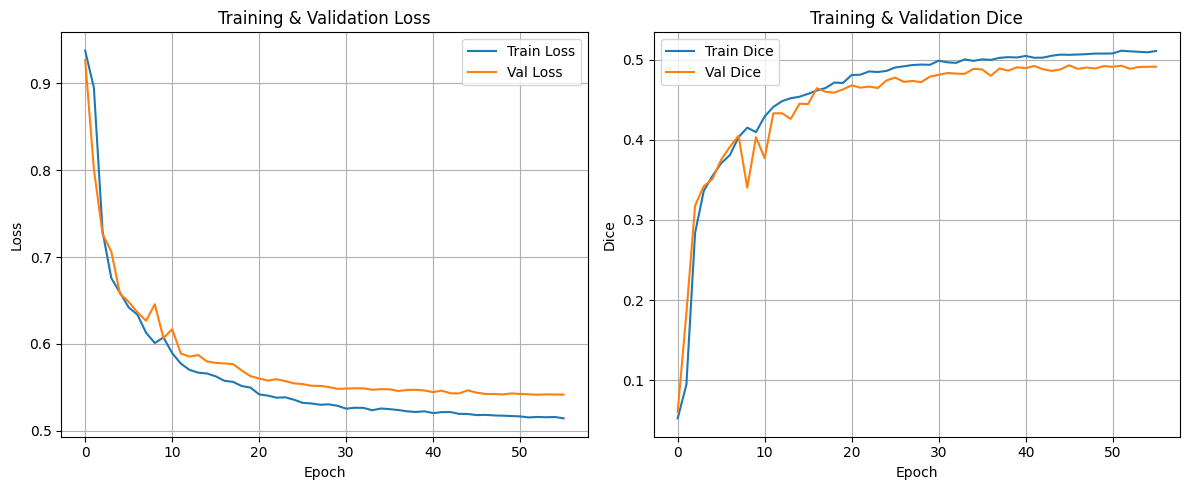

In [10]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.title("Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    # Dice
    plt.subplot(1, 2, 2)
    plt.plot(history.history["dice"], label="Train Dice")
    plt.plot(history.history["val_dice"], label="Val Dice")
    plt.title("Training & Validation Dice")
    plt.xlabel("Epoch")
    plt.ylabel("Dice")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)


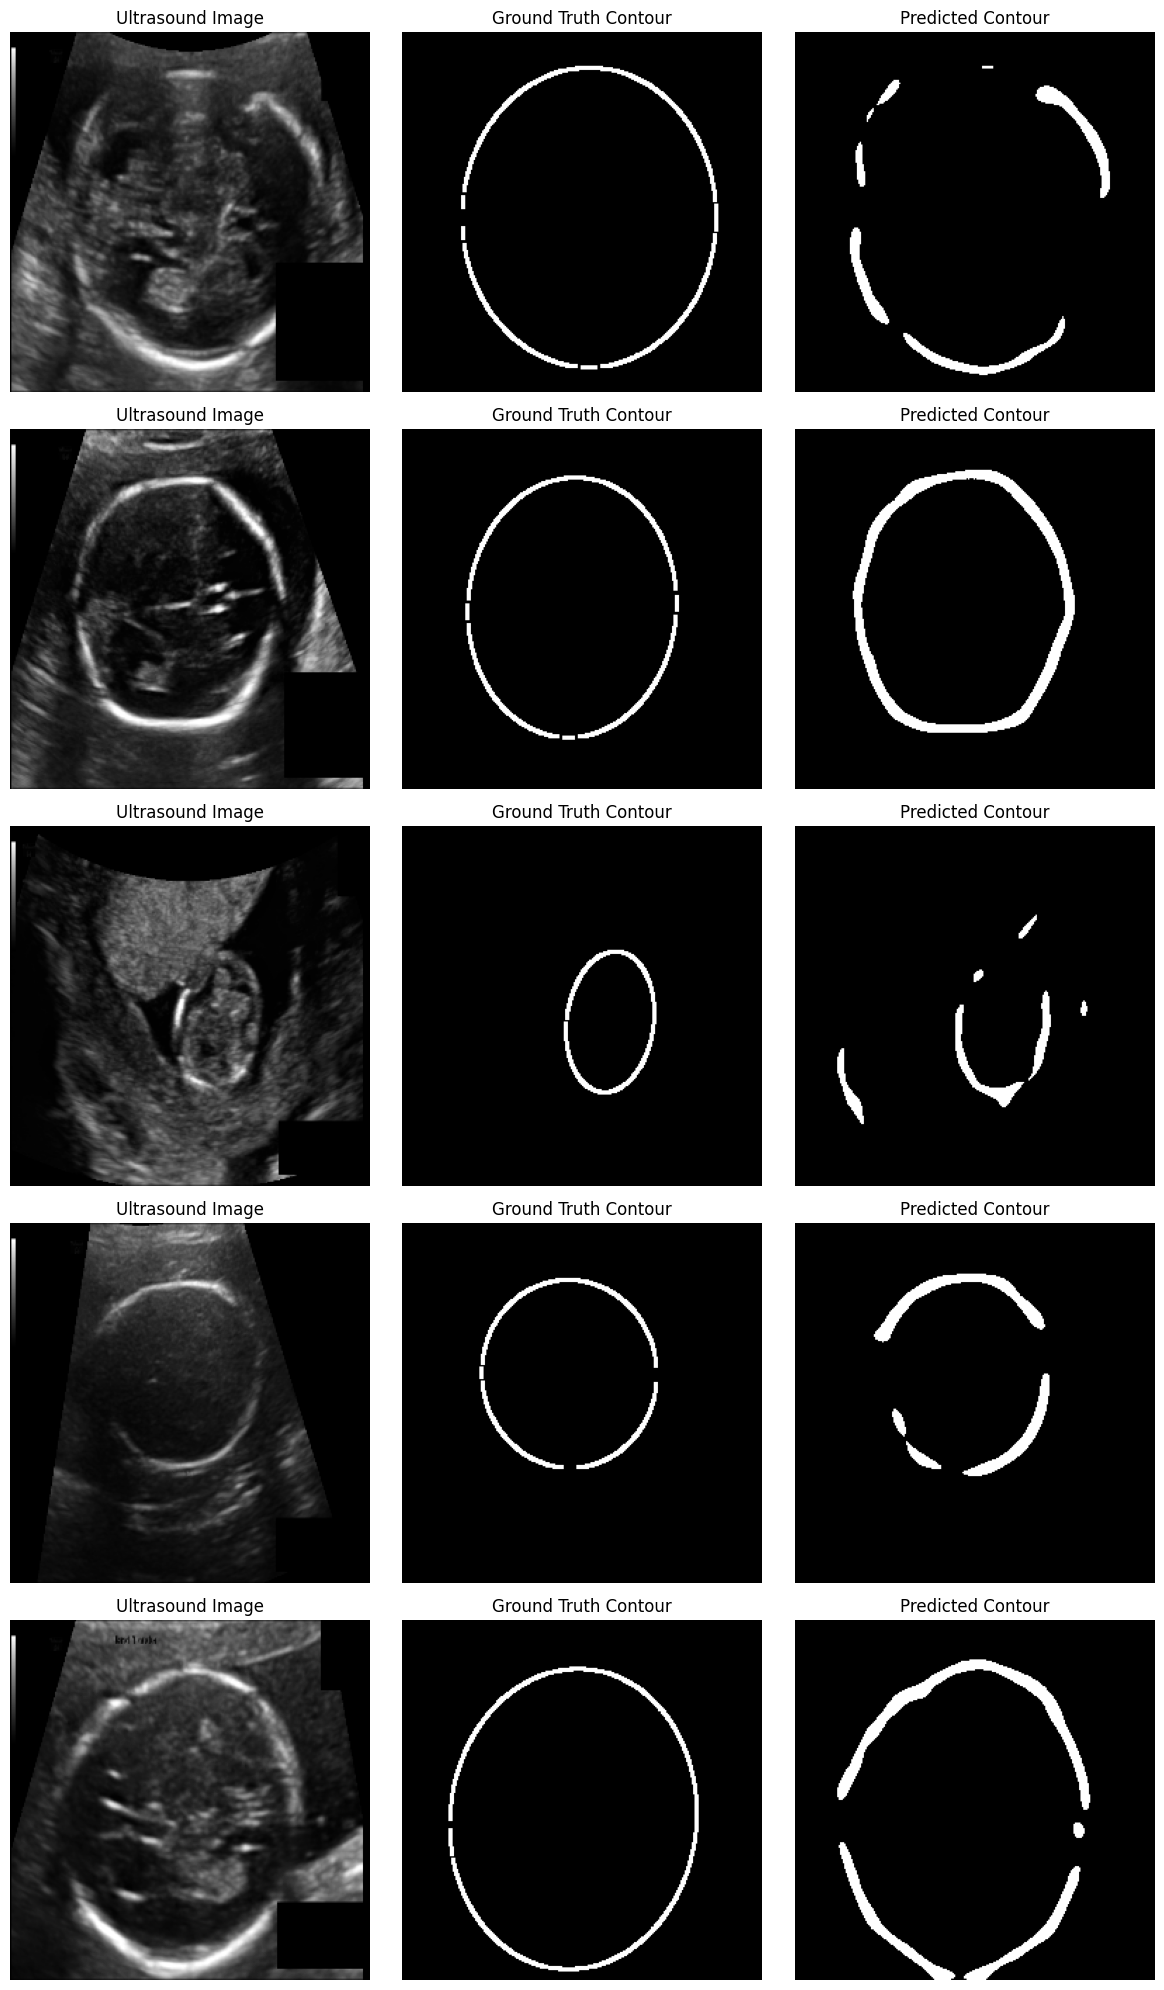

In [11]:
import random

def visualize_predictions(model, dataset, num_samples=5):
    samples = []
    for img, mask in dataset.unbatch():
        samples.append((img.numpy(), mask.numpy()))
    selected = random.sample(samples, num_samples)

    plt.figure(figsize=(12, 4 * num_samples))

    for i, (img, gt) in enumerate(selected):
        pred = model.predict(img[np.newaxis, ...], verbose=0)[0]
        pred_bin = (pred > 0.5).astype(np.uint8)

        # Original image
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(img.squeeze(), cmap="gray")
        plt.title("Ultrasound Image")
        plt.axis("off")

        # Ground truth
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(gt.squeeze(), cmap="gray")
        plt.title("Ground Truth Contour")
        plt.axis("off")

        # Prediction
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(pred_bin.squeeze(), cmap="gray")
        plt.title("Predicted Contour")
        plt.axis("off")

    plt.tight_layout()
    plt.show()
visualize_predictions(model, test_ds, num_samples=5)

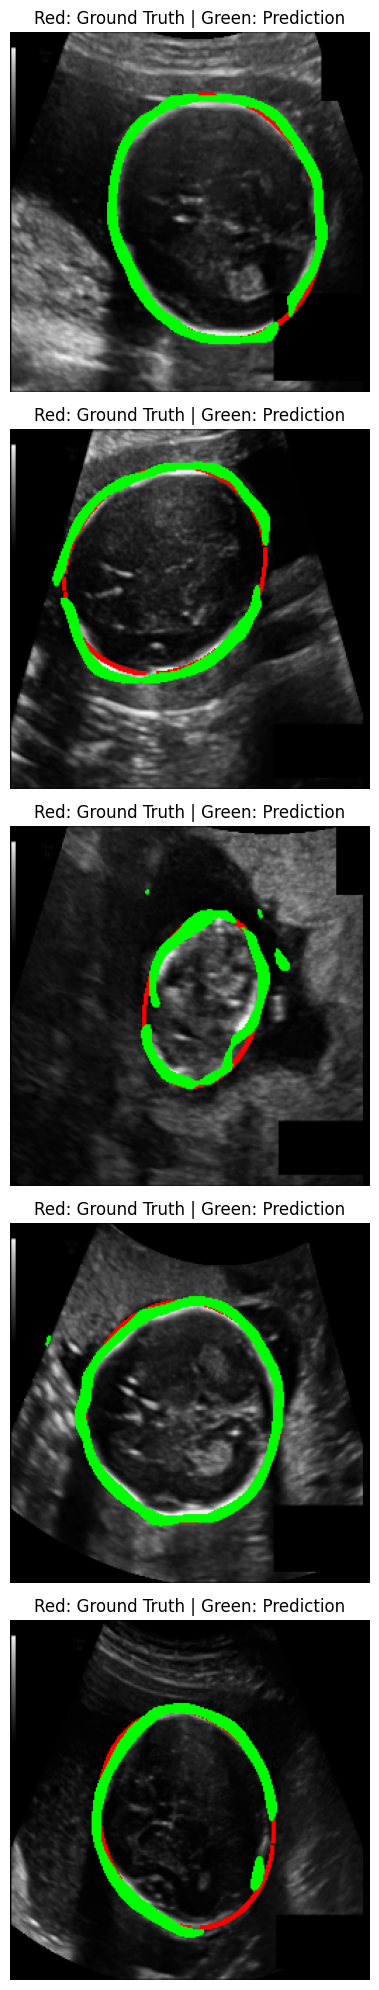

In [12]:
def visualize_overlay(model, dataset, num_samples=5):
    samples = []
    for img, mask in dataset.unbatch():
        samples.append((img.numpy(), mask.numpy()))
    selected = random.sample(samples, num_samples)

    plt.figure(figsize=(12, 4 * num_samples))

    for i, (img, gt) in enumerate(selected):
        pred = model.predict(img[np.newaxis, ...], verbose=0)[0]
        pred_bin = (pred > 0.5).astype(np.uint8)

        # Create RGB image
        img_rgb = np.repeat(img, 3, axis=-1)

        overlay = img_rgb.copy()
        overlay[gt.squeeze() > 0] = [1, 0, 0]    # Red = GT
        overlay[pred_bin.squeeze() > 0] = [0, 1, 0]  # Green = Pred

        plt.subplot(num_samples, 1, i + 1)
        plt.imshow(overlay)
        plt.title("Red: Ground Truth | Green: Prediction")
        plt.axis("off")

    plt.tight_layout()
    plt.show()
visualize_overlay(model, test_ds, num_samples=5)

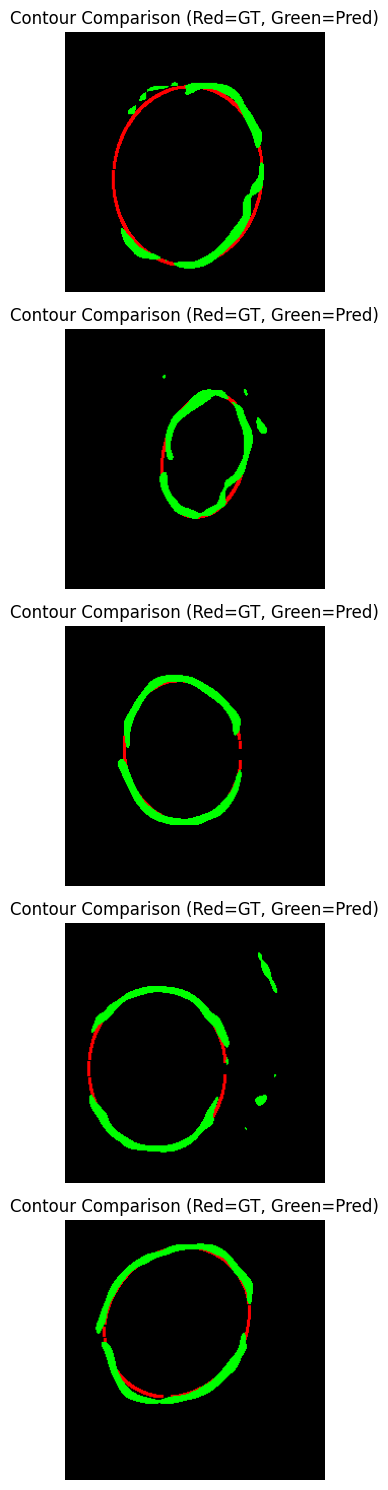

In [14]:
def visualize_contours_only(model, dataset, num_samples=5):
    samples = []
    for img, mask in dataset.unbatch():
        samples.append((img.numpy(), mask.numpy()))
    selected = random.sample(samples, num_samples)

    plt.figure(figsize=(10, 3 * num_samples))

    for i, (img, gt) in enumerate(selected):
        pred = model.predict(img[np.newaxis, ...], verbose=0)[0]
        pred_bin = (pred > 0.5).astype(np.uint8)

        canvas = np.zeros((*img.shape[:2], 3))
        canvas[gt.squeeze() > 0] = [1, 0, 0]     # GT = red
        canvas[pred_bin.squeeze() > 0] = [0, 1, 0]  # Pred = green

        plt.subplot(num_samples, 1, i + 1)
        plt.imshow(canvas)
        plt.title("Contour Comparison (Red=GT, Green=Pred)")
        plt.axis("off")

    plt.tight_layout()
    plt.show()
visualize_contours_only(model, test_ds, num_samples=5)
